# Identifying Similar Questions

## Univeral Encoder 

Link to Data: https://www.kaggle.com/mysarahmadbhat/quora-questions-duplicacy

## Notebook Results

| Model                         | True Positive | True Negative  | False Positive | False Negative | Accuracy | Precision | Recall | F1-Score | AOC AUC | Log Loss |
|-------------------------------|---------------|----------------|----------------|----------------|----------|-----------|--------|----------|---------|----------|
| Universal Encoder |**2672**       |**5538**        |**955**        |**835**         |**0.8210**|**0.7619** | **0.7367**|**0.7491**|**0.9021**|**0.3864**|

**Imports**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import official.nlp.bert.tokenization as tokenization
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.style.use('ggplot')

**Import the datasets**

In [12]:
df = pd.read_csv('../quora.csv', index_col=0)
df['is_duplicate'] = df['is_duplicate'].astype(int) 
df.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


**Splitting the data into training and testing sets**

In [13]:
num_samples = df.shape[0]
training_samples = int(num_samples * 0.9)
testing_samples = int(num_samples * 0.1)
print('{} number of samples'.format(num_samples))
print('{} training samples'.format(training_samples))
print('{} testing samples'.format(num_samples - training_samples))

100000 number of samples
90000 training samples
10000 testing samples


I am shuffling and splitting the dataset manually in order to preserve the questions in the same index as the embeddings. This will allow me to look at which questions I got wrong by comparing indexes of the incorrect predictions and finding the questions themselves.

In [14]:
### Shuffle both datasets
df_suffled = df.sample(frac=1, random_state=42).reset_index(drop=True).copy()

In [15]:
questions = df_suffled[['question1','question2']]
labels = df_suffled['is_duplicate'].astype(int)

X_train = questions[:training_samples]
y_train = labels[:training_samples]
X_test = questions[training_samples:]
y_test = labels[training_samples:]

### Create a validation set of 20,000 from the training data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=20000)

X_train_q1 = X_train['question1']
X_train_q2 = X_train['question2']
X_val_q1 = X_val['question1']
X_val_q2 = X_val['question2']
X_test_q1 = X_test['question1']
X_test_q2 = X_test['question2']

print(X_train_q1.shape)
print(X_train_q2.shape)
print(X_val_q1.shape)
print(X_val_q2.shape)
print(X_test_q1.shape)
print(X_test_q2.shape)
# Labels
print(y_test.shape)
print(y_train.shape)

(70000,)
(70000,)
(20000,)
(20000,)
(10000,)
(10000,)
(10000,)
(70000,)


In [20]:
### Input                      
question_1_input = tf.keras.layers.Input(shape=[], dtype=tf.string)
question_2_input = tf.keras.layers.Input(shape=[], dtype=tf.string)
question_1_embeddings = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', trainable=False)(question_1_input)
question_2_embeddings = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', trainable=False)(question_2_input)
         
concat = tf.keras.layers.concatenate([question_1_embeddings, question_2_embeddings])

x = tf.keras.layers.Dense(512, activation='relu')(concat)
x = tf.keras.layers.Dropout(0.4)(x) 
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
                      
model = tf.keras.models.Model(inputs=[question_1_input, question_2_input], 
                              outputs=output)

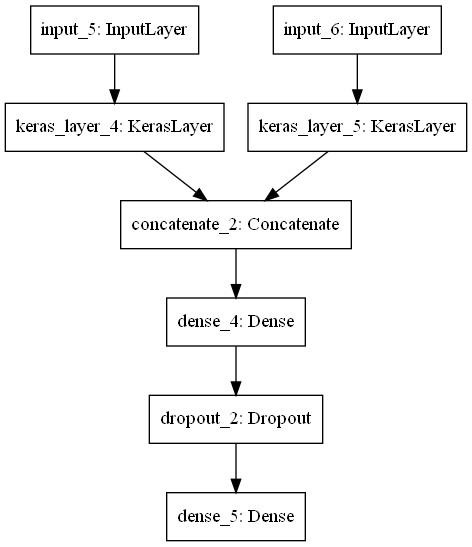

In [21]:
tf.keras.utils.plot_model(model)

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      (None, 512)          256797824   input_5[0][0]                    
__________________________________________________________________________________________________
keras_layer_5 (KerasLayer)      (None, 512)          256797824   input_6[0][0]                    
____________________________________________________________________________________________

In [24]:
early_stopping = EarlyStopping(patience=5, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=True, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=2, # Reduce after 3 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.2, # Reduce by a factor of 2/10
                              min_delta=0.001, # Minimumn change needed
                              verbose=1)

history = model.fit([X_train_q1, X_train_q2],
                    y_train, 
                    epochs=50,
                    batch_size=128,
                    validation_data=([X_val_q1, X_val_q2], y_val),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/50
547/547 [==============================] - 16s 26ms/step - loss: 0.5520 - accuracy: 0.7209 - val_loss: 0.5065 - val_accuracy: 0.7545
Epoch 2/50
547/547 [==============================] - 14s 26ms/step - loss: 0.4756 - accuracy: 0.7680 - val_loss: 0.4624 - val_accuracy: 0.7740
Epoch 3/50
547/547 [==============================] - 13s 24ms/step - loss: 0.4296 - accuracy: 0.7942 - val_loss: 0.4373 - val_accuracy: 0.7865
Epoch 4/50
547/547 [==============================] - 13s 24ms/step - loss: 0.3931 - accuracy: 0.8161 - val_loss: 0.4286 - val_accuracy: 0.7887
Epoch 5/50
547/547 [==============================] - 13s 24ms/step - loss: 0.3675 - accuracy: 0.8315 - val_loss: 0.4126 - val_accuracy: 0.7994
Epoch 6/50
547/547 [==============================] - 13s 24ms/step - loss: 0.3407 - accuracy: 0.8465 - val_loss: 0.4031 - val_accuracy: 0.8045
Epoch 7/50
547/547 [==============================] - 14s 25ms/step - loss: 0.3173 - accuracy: 0.8602 - val_loss: 0.3990 - val_accuracy:


Lowest Validation Loss: 0.3942 on epoch 14
Highest Validation Accuracy: 0.8192 on epoch 14


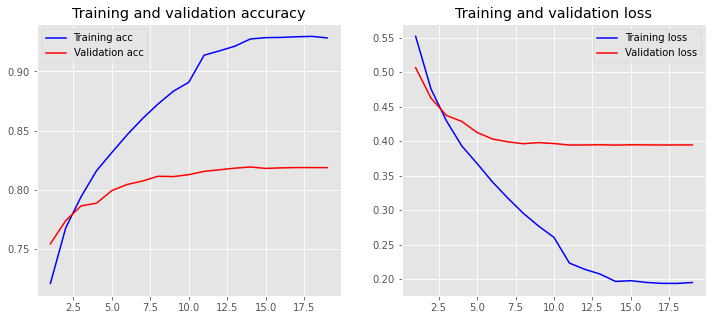

In [25]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    highest_val_acc_epoch = np.argmax(val_acc)+1
    print("\nLowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))
    print("Highest Validation Accuracy: {:.4f} on epoch {}".format(np.max(val_acc), highest_val_acc_epoch))

plot_history(history)

**Checking for metrics**

Below I create two functions to help visuals some important metrics to gauge each machine models performance. 

In [26]:
def calc_precision_recall(y_true, y_pred):
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)  
    # Instantiate counters
    TP = FP = FN = 0
    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1    
    # Calculate true positive rate and false positive rate
    precision = (TP / (TP + FP)) if (TP + FP != 0) else 1
    recall = (TP / (TP + FN)) if (TP + FN != 0) else 1
    return precision, recall

def print_metrics(y_test, y_pred, y_prob, model_name):
    
    target_names=['Duplicate','Not Duplicate']
    
    tp = ((y_test==1) & (y_pred==1)).sum()
    tn = ((y_test==0) & (y_pred==0)).sum()
    fp = ((y_test==1) & (y_pred==0)).sum()
    fn = ((y_test==0) & (y_pred==1)).sum()
    
    precision , recall = calc_precision_recall(y_test, y_pred)
    
    print("True Positive:",tp)
    print("True Negative:",tn)
    print("False Positive (Type 1 error):",fp)
    print("False Negative (Type 2 error):",fn)
    print("Accuracy: {:.4f}".format((y_pred == y_test).mean()))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format((2*precision*recall)/(precision+recall)))
    print("Log Loss: {:.4f}".format(log_loss(y_test, y_prob)))
    
    # Containers for true positive / false positive rates
    precision_scores = []
    recall_scores = []

    # Define probability thresholds to use, between 0 and 1
    probability_thresholds = np.linspace(0, 1, num=100)

    # Find true positive / false positive rate for each threshold
    for p in probability_thresholds:
        y_test_preds = []
        for prob in y_prob:
            if prob > p:
                y_test_preds.append(1)
            else:
                y_test_preds.append(0)
        precision, recall = calc_precision_recall(y_test, y_test_preds)
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    ### Starting Visuals
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    
    ### Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame([cm[1][::-1],cm[0][::-1]]), 
                square=True, 
                annot=True, 
                fmt='d', 
                cbar=False, 
                xticklabels=['Duplicate\n(1)','Not Duplicate\n(0)'], 
                yticklabels=['Duplicate (1)','Not Duplicate (0)'], 
                cmap="YlGnBu",
                ax=axes[0])
    plt.sca(axes[0])
    plt.title("Predicted Value")
    plt.yticks(horizontalalignment='right', rotation=0)
    plt.ylabel("True\nValue", rotation=0)

    ### ROC AUC 
    roc_score = "ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    # plot model roc curve
    axes[1].plot([0, 1], [0, 1], linestyle='--')
    axes[1].plot(fpr, tpr, marker='.', label=roc_score)
    plt.sca(axes[1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Postivie Rate')
    plt.legend()
    
    ### Precision Recall
    baseline = len(y_test[y_test==1]) / len(y_test)
    axes[2].plot(recall_scores, precision_scores, label=model_name)
    axes[2].plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.sca(axes[2])
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    fig.tight_layout()

Predicting on the testing data

In [27]:
y_prob = model.predict([X_test_q1, X_test_q2])
y_hat = (y_prob > 0.5).astype(int).flatten()

Visualizing the predictions

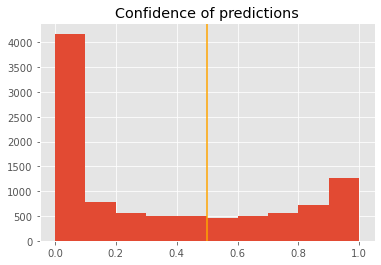

In [28]:
plt.hist(y_prob)
_ = plt.axvline(x=0.5, color='orange') ### Fitting the traditional .5 accuracy threshold is
plt.title('Confidence of predictions');

Looking at the metrics

True Positive: 2672
True Negative: 5538
False Positive (Type 1 error): 955
False Negative (Type 2 error): 835
Accuracy: 0.8210
Precision: 0.7619
Recall: 0.7367
F1-Score: 0.7491
Log Loss: 0.3864


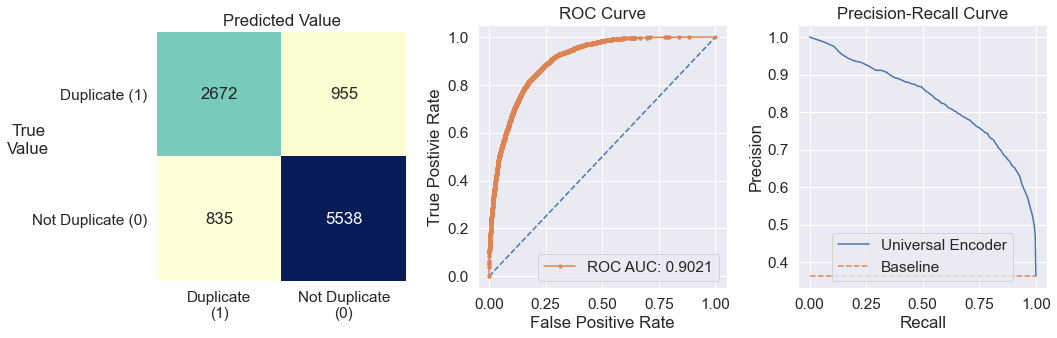

In [32]:
print_metrics(y_test, y_hat, y_prob, 'Universal Encoder')

**Looking at the questions the model incorrectly predicted**

Below I created a function to print out *n* amount of wrong answers from both kinds of errors

In [30]:
def print_wrong_responses(y_test, y_pred, X_test_qs, n=5):
    print("""##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)\n""")
    [print(f"Question 1:{X_test_qs['question1'].loc[example]}\nQuestion 2:{X_test_qs['question2'].loc[example]}", "\n") for example in X_test[(y_test == 0) & (y_pred == 1)].index[:n]]
    
    print("""##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)\n""")
    [print(f"Question 1:{X_test_qs['question1'].loc[example]}\nQuestion 2:{X_test_qs['question2'].loc[example]}", "\n") for example in X_test[(y_test == 1) & (y_pred == 0)].index[:n]]

In [31]:
print_wrong_responses(y_test, y_hat, X_test, n=5)

##############################################################
    Predicted True (y_hat = 1) but actually False (y_test = 0)
    (TYPE 1 ERROR)

Question 1:What are the questions asked in SSB interviews?
Question 2:What questions are asked in an NDA SSB interview? 

Question 1:What are the best technology inventions of 2014?
Question 2:What are the best technology inventions? 

Question 1:What are the best books by Indian authors?
Question 2:What are some good Indian novels? 

Question 1:What are some mind-blowing futuristic gadgets that exist that most people don't know about?
Question 2:What are some mind-blowing wallets gadgets that exist that most people don't know about? 

Question 1:How can I feel positive always?
Question 2:How should we feel positive? 

##############################################################
    Predicted False (y_hat = 0) but actually True (y_test = 1)
    (TYPE 2 ERROR)

Question 1:How do you determine the value of a 1946 wheat penny?
Question 2:What 